In [2]:
import os

# Collect all filenames under /kaggle/input, but do NOT print
file_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

# Optional: Show just how many files were found
print(f"Total files found: {len(file_paths)}")


Total files found: 261080


In [3]:
json_files = [f for f in file_paths if f.endswith('.json')]
print(f"Found {len(json_files)} JSON files")

Found 14 JSON files


In [4]:
import os
import json
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm

# Set device use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet-50 and remove classifier layer
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval().to(device)

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_root = '/kaggle/input/polyvore-outfit-dataset/polyvore_outfits'
img_dir = os.path.join(dataset_root, 'images')
metadata_path = os.path.join(dataset_root, 'polyvore_item_metadata.json')

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Only allow individual fashion items (not outfit/model images)
valid_categories = {"tops", "blouses", "shirts", "t-shirts", 
                    "pants", "skirts", "shorts", "jeans", "trousers", "bottoms", 
                    "shoes","boots", "heels", "sneakers", "sandals", 
                    "bags", "handbags", "purses", "clutches"}

# Filter image paths
image_ids, image_paths, image_categories = [], [], {}
for img_id, details in metadata.items():
    cat = details.get("semantic_category")
    if cat in valid_categories:
        img_path = os.path.join(img_dir, f"{img_id}.jpg")
        if os.path.exists(img_path):
            image_ids.append(img_id)
            image_paths.append(img_path)
            image_categories[img_id] = cat

print(f"Total individual fashion item images to process: {len(image_paths)}")

# Feature extraction
batch_size = 128
image_features = {}

for i in tqdm(range(0, len(image_paths), batch_size)):
    
    if i % 320 == 0:  # Every 5 batches (64*5=320)
        print(f"Processed {i}/{len(image_paths)} images", flush=True)
         
    batch_paths = image_paths[i:i + batch_size]
    batch_ids = image_ids[i:i + batch_size]

    images, valid_ids = [], []

    for img_path, img_id in zip(batch_paths, batch_ids):
        try:
            image = Image.open(img_path).convert("RGB")
            image = transform(image)
            images.append(image)
            valid_ids.append(img_id)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            continue

    if not images:
        continue

    images_tensor = torch.stack(images).to(device)

    with torch.no_grad():
        features = model(images_tensor).squeeze(-1).squeeze(-1).cpu().numpy()

    for img_id, feat in zip(valid_ids, features):
        image_features[img_id] = feat

print(f"Extracted features for {len(image_features)} individual items.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


Total individual fashion item images to process: 146235


  0%|          | 0/1143 [00:00<?, ?it/s]

Processed 0/146235 images


  0%|          | 5/1143 [00:05<18:14,  1.04it/s]

Processed 640/146235 images


  1%|          | 10/1143 [00:09<16:48,  1.12it/s]

Processed 1280/146235 images


  1%|▏         | 15/1143 [00:14<17:38,  1.07it/s]

Processed 1920/146235 images


  2%|▏         | 20/1143 [00:18<17:03,  1.10it/s]

Processed 2560/146235 images


  2%|▏         | 25/1143 [00:23<16:55,  1.10it/s]

Processed 3200/146235 images


  3%|▎         | 30/1143 [00:28<17:11,  1.08it/s]

Processed 3840/146235 images


  3%|▎         | 35/1143 [00:32<16:42,  1.10it/s]

Processed 4480/146235 images


  3%|▎         | 40/1143 [00:37<16:23,  1.12it/s]

Processed 5120/146235 images


  4%|▍         | 45/1143 [00:41<16:31,  1.11it/s]

Processed 5760/146235 images


  4%|▍         | 50/1143 [00:46<16:39,  1.09it/s]

Processed 6400/146235 images


  5%|▍         | 55/1143 [00:50<16:04,  1.13it/s]

Processed 7040/146235 images


  5%|▌         | 60/1143 [00:54<15:56,  1.13it/s]

Processed 7680/146235 images


  6%|▌         | 65/1143 [00:59<16:19,  1.10it/s]

Processed 8320/146235 images


  6%|▌         | 70/1143 [01:03<16:00,  1.12it/s]

Processed 8960/146235 images


  7%|▋         | 75/1143 [01:08<15:48,  1.13it/s]

Processed 9600/146235 images


  7%|▋         | 80/1143 [01:13<16:01,  1.11it/s]

Processed 10240/146235 images


  7%|▋         | 85/1143 [01:17<16:03,  1.10it/s]

Processed 10880/146235 images


  8%|▊         | 90/1143 [01:22<16:22,  1.07it/s]

Processed 11520/146235 images


  8%|▊         | 95/1143 [01:26<15:57,  1.09it/s]

Processed 12160/146235 images


  9%|▊         | 100/1143 [01:31<16:30,  1.05it/s]

Processed 12800/146235 images


  9%|▉         | 105/1143 [01:36<15:56,  1.08it/s]

Processed 13440/146235 images


 10%|▉         | 110/1143 [01:40<15:38,  1.10it/s]

Processed 14080/146235 images


 10%|█         | 115/1143 [01:45<16:09,  1.06it/s]

Processed 14720/146235 images


 10%|█         | 120/1143 [01:50<15:45,  1.08it/s]

Processed 15360/146235 images


 11%|█         | 125/1143 [01:54<15:36,  1.09it/s]

Processed 16000/146235 images


 11%|█▏        | 130/1143 [01:59<15:19,  1.10it/s]

Processed 16640/146235 images


 12%|█▏        | 135/1143 [02:03<15:08,  1.11it/s]

Processed 17280/146235 images


 12%|█▏        | 140/1143 [02:08<15:02,  1.11it/s]

Processed 17920/146235 images


 13%|█▎        | 145/1143 [02:12<15:18,  1.09it/s]

Processed 18560/146235 images


 13%|█▎        | 150/1143 [02:17<15:19,  1.08it/s]

Processed 19200/146235 images


 14%|█▎        | 155/1143 [02:22<15:02,  1.10it/s]

Processed 19840/146235 images


 14%|█▍        | 160/1143 [02:26<14:55,  1.10it/s]

Processed 20480/146235 images


 14%|█▍        | 165/1143 [02:31<14:41,  1.11it/s]

Processed 21120/146235 images


 15%|█▍        | 170/1143 [02:36<14:58,  1.08it/s]

Processed 21760/146235 images


 15%|█▌        | 175/1143 [02:40<14:38,  1.10it/s]

Processed 22400/146235 images


 16%|█▌        | 180/1143 [02:45<14:33,  1.10it/s]

Processed 23040/146235 images


 16%|█▌        | 185/1143 [02:49<14:11,  1.12it/s]

Processed 23680/146235 images


 17%|█▋        | 190/1143 [02:54<14:21,  1.11it/s]

Processed 24320/146235 images


 17%|█▋        | 195/1143 [02:58<13:42,  1.15it/s]

Processed 24960/146235 images


 17%|█▋        | 200/1143 [03:02<13:48,  1.14it/s]

Processed 25600/146235 images


 18%|█▊        | 205/1143 [03:07<14:00,  1.12it/s]

Processed 26240/146235 images


 18%|█▊        | 210/1143 [03:11<13:54,  1.12it/s]

Processed 26880/146235 images


 19%|█▉        | 215/1143 [03:16<13:55,  1.11it/s]

Processed 27520/146235 images


 19%|█▉        | 220/1143 [03:20<13:49,  1.11it/s]

Processed 28160/146235 images


 20%|█▉        | 225/1143 [03:25<13:41,  1.12it/s]

Processed 28800/146235 images


 20%|██        | 230/1143 [03:29<14:04,  1.08it/s]

Processed 29440/146235 images


 21%|██        | 235/1143 [03:34<13:34,  1.11it/s]

Processed 30080/146235 images


 21%|██        | 240/1143 [03:38<13:23,  1.12it/s]

Processed 30720/146235 images


 21%|██▏       | 245/1143 [03:43<13:02,  1.15it/s]

Processed 31360/146235 images


 22%|██▏       | 250/1143 [03:47<13:06,  1.14it/s]

Processed 32000/146235 images


 22%|██▏       | 255/1143 [03:51<12:46,  1.16it/s]

Processed 32640/146235 images


 23%|██▎       | 260/1143 [03:56<12:56,  1.14it/s]

Processed 33280/146235 images


 23%|██▎       | 265/1143 [04:00<12:54,  1.13it/s]

Processed 33920/146235 images


 24%|██▎       | 270/1143 [04:05<12:51,  1.13it/s]

Processed 34560/146235 images


 24%|██▍       | 275/1143 [04:09<12:57,  1.12it/s]

Processed 35200/146235 images


 24%|██▍       | 280/1143 [04:14<13:13,  1.09it/s]

Processed 35840/146235 images


 25%|██▍       | 285/1143 [04:18<12:46,  1.12it/s]

Processed 36480/146235 images


 25%|██▌       | 290/1143 [04:22<12:32,  1.13it/s]

Processed 37120/146235 images


 26%|██▌       | 295/1143 [04:27<12:39,  1.12it/s]

Processed 37760/146235 images


 26%|██▌       | 300/1143 [04:32<12:58,  1.08it/s]

Processed 38400/146235 images


 27%|██▋       | 305/1143 [04:36<13:22,  1.04it/s]

Processed 39040/146235 images


 27%|██▋       | 310/1143 [04:41<12:46,  1.09it/s]

Processed 39680/146235 images


 28%|██▊       | 315/1143 [04:45<12:23,  1.11it/s]

Processed 40320/146235 images


 28%|██▊       | 320/1143 [04:50<11:54,  1.15it/s]

Processed 40960/146235 images


 28%|██▊       | 325/1143 [04:54<11:56,  1.14it/s]

Processed 41600/146235 images


 29%|██▉       | 330/1143 [04:58<11:41,  1.16it/s]

Processed 42240/146235 images


 29%|██▉       | 335/1143 [05:03<11:49,  1.14it/s]

Processed 42880/146235 images


 30%|██▉       | 340/1143 [05:07<11:33,  1.16it/s]

Processed 43520/146235 images


 30%|███       | 345/1143 [05:12<11:55,  1.11it/s]

Processed 44160/146235 images


 31%|███       | 350/1143 [05:16<11:43,  1.13it/s]

Processed 44800/146235 images


 31%|███       | 355/1143 [05:20<11:29,  1.14it/s]

Processed 45440/146235 images


 31%|███▏      | 360/1143 [05:25<11:33,  1.13it/s]

Processed 46080/146235 images


 32%|███▏      | 365/1143 [05:29<11:37,  1.12it/s]

Processed 46720/146235 images


 32%|███▏      | 370/1143 [05:34<11:32,  1.12it/s]

Processed 47360/146235 images


 33%|███▎      | 375/1143 [05:38<11:28,  1.12it/s]

Processed 48000/146235 images


 33%|███▎      | 380/1143 [05:43<12:02,  1.06it/s]

Processed 48640/146235 images


 34%|███▎      | 385/1143 [05:47<11:07,  1.14it/s]

Processed 49280/146235 images


 34%|███▍      | 390/1143 [05:52<11:18,  1.11it/s]

Processed 49920/146235 images


 35%|███▍      | 395/1143 [05:56<11:17,  1.10it/s]

Processed 50560/146235 images


 35%|███▍      | 400/1143 [06:01<11:06,  1.11it/s]

Processed 51200/146235 images


 35%|███▌      | 405/1143 [06:05<10:55,  1.13it/s]

Processed 51840/146235 images


 36%|███▌      | 410/1143 [06:10<10:47,  1.13it/s]

Processed 52480/146235 images


 36%|███▋      | 415/1143 [06:14<11:35,  1.05it/s]

Processed 53120/146235 images


 37%|███▋      | 420/1143 [06:19<11:05,  1.09it/s]

Processed 53760/146235 images


 37%|███▋      | 425/1143 [06:24<10:59,  1.09it/s]

Processed 54400/146235 images


 38%|███▊      | 430/1143 [06:28<11:14,  1.06it/s]

Processed 55040/146235 images


 38%|███▊      | 435/1143 [06:33<11:32,  1.02it/s]

Processed 55680/146235 images


 38%|███▊      | 440/1143 [06:38<11:09,  1.05it/s]

Processed 56320/146235 images


 39%|███▉      | 445/1143 [06:43<11:03,  1.05it/s]

Processed 56960/146235 images


 39%|███▉      | 450/1143 [06:48<11:17,  1.02it/s]

Processed 57600/146235 images


 40%|███▉      | 455/1143 [06:52<10:57,  1.05it/s]

Processed 58240/146235 images


 40%|████      | 460/1143 [06:57<10:47,  1.05it/s]

Processed 58880/146235 images


 41%|████      | 465/1143 [07:02<10:30,  1.08it/s]

Processed 59520/146235 images


 41%|████      | 470/1143 [07:06<10:29,  1.07it/s]

Processed 60160/146235 images


 42%|████▏     | 475/1143 [07:11<10:35,  1.05it/s]

Processed 60800/146235 images


 42%|████▏     | 480/1143 [07:16<10:55,  1.01it/s]

Processed 61440/146235 images


 42%|████▏     | 485/1143 [07:21<11:07,  1.01s/it]

Processed 62080/146235 images


 43%|████▎     | 490/1143 [07:26<10:36,  1.03it/s]

Processed 62720/146235 images


 43%|████▎     | 495/1143 [07:31<10:39,  1.01it/s]

Processed 63360/146235 images


 44%|████▎     | 500/1143 [07:36<10:35,  1.01it/s]

Processed 64000/146235 images


 44%|████▍     | 505/1143 [07:41<10:21,  1.03it/s]

Processed 64640/146235 images


 45%|████▍     | 510/1143 [07:46<10:13,  1.03it/s]

Processed 65280/146235 images


 45%|████▌     | 515/1143 [07:51<10:22,  1.01it/s]

Processed 65920/146235 images


 45%|████▌     | 520/1143 [07:55<10:14,  1.01it/s]

Processed 66560/146235 images


 46%|████▌     | 525/1143 [08:00<09:56,  1.04it/s]

Processed 67200/146235 images


 46%|████▋     | 530/1143 [08:05<09:46,  1.05it/s]

Processed 67840/146235 images


 47%|████▋     | 535/1143 [08:10<09:44,  1.04it/s]

Processed 68480/146235 images


 47%|████▋     | 540/1143 [08:15<09:58,  1.01it/s]

Processed 69120/146235 images


 48%|████▊     | 545/1143 [08:20<09:51,  1.01it/s]

Processed 69760/146235 images


 48%|████▊     | 550/1143 [08:25<09:50,  1.00it/s]

Processed 70400/146235 images


 49%|████▊     | 555/1143 [08:30<09:45,  1.00it/s]

Processed 71040/146235 images


 49%|████▉     | 560/1143 [08:35<09:49,  1.01s/it]

Processed 71680/146235 images


 49%|████▉     | 565/1143 [08:40<09:40,  1.00s/it]

Processed 72320/146235 images


 50%|████▉     | 570/1143 [08:45<09:40,  1.01s/it]

Processed 72960/146235 images


 50%|█████     | 575/1143 [08:50<09:31,  1.01s/it]

Processed 73600/146235 images


 51%|█████     | 580/1143 [08:55<09:28,  1.01s/it]

Processed 74240/146235 images


 51%|█████     | 585/1143 [09:00<09:22,  1.01s/it]

Processed 74880/146235 images


 52%|█████▏    | 590/1143 [09:05<09:02,  1.02it/s]

Processed 75520/146235 images


 52%|█████▏    | 595/1143 [09:10<08:51,  1.03it/s]

Processed 76160/146235 images


 52%|█████▏    | 600/1143 [09:15<09:30,  1.05s/it]

Processed 76800/146235 images


 53%|█████▎    | 605/1143 [09:20<08:51,  1.01it/s]

Processed 77440/146235 images


 53%|█████▎    | 610/1143 [09:25<09:10,  1.03s/it]

Processed 78080/146235 images


 54%|█████▍    | 615/1143 [09:30<08:55,  1.01s/it]

Processed 78720/146235 images


 54%|█████▍    | 620/1143 [09:35<08:47,  1.01s/it]

Processed 79360/146235 images


 55%|█████▍    | 625/1143 [09:40<08:37,  1.00it/s]

Processed 80000/146235 images


 55%|█████▌    | 630/1143 [09:45<08:35,  1.00s/it]

Processed 80640/146235 images


 56%|█████▌    | 635/1143 [09:50<08:17,  1.02it/s]

Processed 81280/146235 images


 56%|█████▌    | 640/1143 [09:55<08:09,  1.03it/s]

Processed 81920/146235 images


 56%|█████▋    | 645/1143 [10:00<08:04,  1.03it/s]

Processed 82560/146235 images


 57%|█████▋    | 650/1143 [10:05<07:52,  1.04it/s]

Processed 83200/146235 images


 57%|█████▋    | 655/1143 [10:10<07:49,  1.04it/s]

Processed 83840/146235 images


 58%|█████▊    | 660/1143 [10:15<08:09,  1.01s/it]

Processed 84480/146235 images


 58%|█████▊    | 665/1143 [10:20<07:58,  1.00s/it]

Processed 85120/146235 images


 59%|█████▊    | 670/1143 [10:25<08:03,  1.02s/it]

Processed 85760/146235 images


 59%|█████▉    | 675/1143 [10:30<07:54,  1.01s/it]

Processed 86400/146235 images


 59%|█████▉    | 680/1143 [10:35<08:01,  1.04s/it]

Processed 87040/146235 images


 60%|█████▉    | 685/1143 [10:40<07:39,  1.00s/it]

Processed 87680/146235 images


 60%|██████    | 690/1143 [10:45<07:22,  1.02it/s]

Processed 88320/146235 images


 61%|██████    | 695/1143 [10:50<07:21,  1.01it/s]

Processed 88960/146235 images


 61%|██████    | 700/1143 [10:55<07:17,  1.01it/s]

Processed 89600/146235 images


 62%|██████▏   | 705/1143 [11:00<07:20,  1.01s/it]

Processed 90240/146235 images


 62%|██████▏   | 710/1143 [11:05<06:59,  1.03it/s]

Processed 90880/146235 images


 63%|██████▎   | 715/1143 [11:10<07:07,  1.00it/s]

Processed 91520/146235 images


 63%|██████▎   | 720/1143 [11:15<07:01,  1.00it/s]

Processed 92160/146235 images


 63%|██████▎   | 725/1143 [11:20<06:52,  1.01it/s]

Processed 92800/146235 images


 64%|██████▍   | 730/1143 [11:25<07:10,  1.04s/it]

Processed 93440/146235 images


 64%|██████▍   | 735/1143 [11:30<06:56,  1.02s/it]

Processed 94080/146235 images


 65%|██████▍   | 740/1143 [11:35<06:59,  1.04s/it]

Processed 94720/146235 images


 65%|██████▌   | 745/1143 [11:40<06:41,  1.01s/it]

Processed 95360/146235 images


 66%|██████▌   | 750/1143 [11:45<06:36,  1.01s/it]

Processed 96000/146235 images


 66%|██████▌   | 755/1143 [11:50<06:26,  1.00it/s]

Processed 96640/146235 images


 66%|██████▋   | 760/1143 [11:55<06:16,  1.02it/s]

Processed 97280/146235 images


 67%|██████▋   | 765/1143 [12:00<06:08,  1.02it/s]

Processed 97920/146235 images


 67%|██████▋   | 770/1143 [12:05<06:05,  1.02it/s]

Processed 98560/146235 images


 68%|██████▊   | 775/1143 [12:10<06:00,  1.02it/s]

Processed 99200/146235 images


 68%|██████▊   | 780/1143 [12:15<06:11,  1.02s/it]

Processed 99840/146235 images


 69%|██████▊   | 785/1143 [12:20<06:04,  1.02s/it]

Processed 100480/146235 images


 69%|██████▉   | 790/1143 [12:25<05:59,  1.02s/it]

Processed 101120/146235 images


 70%|██████▉   | 795/1143 [12:31<05:54,  1.02s/it]

Processed 101760/146235 images


 70%|██████▉   | 800/1143 [12:36<05:56,  1.04s/it]

Processed 102400/146235 images


 70%|███████   | 805/1143 [12:41<05:32,  1.02it/s]

Processed 103040/146235 images


 71%|███████   | 810/1143 [12:46<05:31,  1.00it/s]

Processed 103680/146235 images


 71%|███████▏  | 815/1143 [12:51<05:25,  1.01it/s]

Processed 104320/146235 images


 72%|███████▏  | 820/1143 [12:55<05:16,  1.02it/s]

Processed 104960/146235 images


 72%|███████▏  | 825/1143 [13:00<05:11,  1.02it/s]

Processed 105600/146235 images


 73%|███████▎  | 830/1143 [13:05<05:00,  1.04it/s]

Processed 106240/146235 images


 73%|███████▎  | 835/1143 [13:10<04:59,  1.03it/s]

Processed 106880/146235 images


 73%|███████▎  | 840/1143 [13:15<04:58,  1.01it/s]

Processed 107520/146235 images


 74%|███████▍  | 845/1143 [13:20<05:00,  1.01s/it]

Processed 108160/146235 images


 74%|███████▍  | 850/1143 [13:25<04:49,  1.01it/s]

Processed 108800/146235 images


 75%|███████▍  | 855/1143 [13:30<04:51,  1.01s/it]

Processed 109440/146235 images


 75%|███████▌  | 860/1143 [13:35<04:44,  1.00s/it]

Processed 110080/146235 images


 76%|███████▌  | 865/1143 [13:40<04:39,  1.00s/it]

Processed 110720/146235 images


 76%|███████▌  | 870/1143 [13:45<04:31,  1.01it/s]

Processed 111360/146235 images


 77%|███████▋  | 875/1143 [13:50<04:25,  1.01it/s]

Processed 112000/146235 images


 77%|███████▋  | 880/1143 [13:55<04:19,  1.01it/s]

Processed 112640/146235 images


 77%|███████▋  | 885/1143 [14:00<04:10,  1.03it/s]

Processed 113280/146235 images


 78%|███████▊  | 890/1143 [14:05<04:06,  1.03it/s]

Processed 113920/146235 images


 78%|███████▊  | 895/1143 [14:10<04:08,  1.00s/it]

Processed 114560/146235 images


 79%|███████▊  | 900/1143 [14:15<04:04,  1.01s/it]

Processed 115200/146235 images


 79%|███████▉  | 905/1143 [14:20<03:54,  1.01it/s]

Processed 115840/146235 images


 80%|███████▉  | 910/1143 [14:25<03:51,  1.01it/s]

Processed 116480/146235 images


 80%|████████  | 915/1143 [14:30<03:51,  1.02s/it]

Processed 117120/146235 images


 80%|████████  | 920/1143 [14:35<03:45,  1.01s/it]

Processed 117760/146235 images


 81%|████████  | 925/1143 [14:40<03:40,  1.01s/it]

Processed 118400/146235 images


 81%|████████▏ | 930/1143 [14:45<03:28,  1.02it/s]

Processed 119040/146235 images


 82%|████████▏ | 935/1143 [14:50<03:22,  1.03it/s]

Processed 119680/146235 images


 82%|████████▏ | 940/1143 [14:54<03:18,  1.02it/s]

Processed 120320/146235 images


 83%|████████▎ | 945/1143 [14:59<03:15,  1.01it/s]

Processed 120960/146235 images


 83%|████████▎ | 950/1143 [15:04<03:05,  1.04it/s]

Processed 121600/146235 images


 84%|████████▎ | 955/1143 [15:09<02:58,  1.05it/s]

Processed 122240/146235 images


 84%|████████▍ | 960/1143 [15:14<03:07,  1.02s/it]

Processed 122880/146235 images


 84%|████████▍ | 965/1143 [15:19<02:57,  1.00it/s]

Processed 123520/146235 images


 85%|████████▍ | 970/1143 [15:24<02:51,  1.01it/s]

Processed 124160/146235 images


 85%|████████▌ | 975/1143 [15:29<02:45,  1.02it/s]

Processed 124800/146235 images


 86%|████████▌ | 980/1143 [15:34<02:43,  1.01s/it]

Processed 125440/146235 images


 86%|████████▌ | 985/1143 [15:39<02:37,  1.01it/s]

Processed 126080/146235 images


 87%|████████▋ | 990/1143 [15:44<02:36,  1.02s/it]

Processed 126720/146235 images


 87%|████████▋ | 995/1143 [15:49<02:26,  1.01it/s]

Processed 127360/146235 images


 87%|████████▋ | 1000/1143 [15:54<02:20,  1.01it/s]

Processed 128000/146235 images


 88%|████████▊ | 1005/1143 [15:59<02:13,  1.03it/s]

Processed 128640/146235 images


 88%|████████▊ | 1010/1143 [16:03<02:06,  1.05it/s]

Processed 129280/146235 images


 89%|████████▉ | 1015/1143 [16:08<02:01,  1.05it/s]

Processed 129920/146235 images


 89%|████████▉ | 1020/1143 [16:13<02:04,  1.01s/it]

Processed 130560/146235 images


 90%|████████▉ | 1025/1143 [16:18<02:00,  1.02s/it]

Processed 131200/146235 images


 90%|█████████ | 1030/1143 [16:23<01:54,  1.01s/it]

Processed 131840/146235 images


 91%|█████████ | 1035/1143 [16:28<01:50,  1.02s/it]

Processed 132480/146235 images


 91%|█████████ | 1040/1143 [16:34<01:49,  1.07s/it]

Processed 133120/146235 images


 91%|█████████▏| 1045/1143 [16:39<01:49,  1.11s/it]

Processed 133760/146235 images


 92%|█████████▏| 1050/1143 [16:45<01:43,  1.12s/it]

Processed 134400/146235 images


 92%|█████████▏| 1055/1143 [16:50<01:36,  1.10s/it]

Processed 135040/146235 images


 93%|█████████▎| 1060/1143 [16:56<01:26,  1.04s/it]

Processed 135680/146235 images


 93%|█████████▎| 1065/1143 [17:01<01:19,  1.02s/it]

Processed 136320/146235 images


 94%|█████████▎| 1070/1143 [17:06<01:13,  1.01s/it]

Processed 136960/146235 images


 94%|█████████▍| 1075/1143 [17:11<01:08,  1.00s/it]

Processed 137600/146235 images


 94%|█████████▍| 1080/1143 [17:16<01:05,  1.03s/it]

Processed 138240/146235 images


 95%|█████████▍| 1085/1143 [17:21<00:59,  1.03s/it]

Processed 138880/146235 images


 95%|█████████▌| 1090/1143 [17:26<00:53,  1.00s/it]

Processed 139520/146235 images


 96%|█████████▌| 1095/1143 [17:31<00:49,  1.03s/it]

Processed 140160/146235 images


 96%|█████████▌| 1100/1143 [17:36<00:44,  1.03s/it]

Processed 140800/146235 images


 97%|█████████▋| 1105/1143 [17:41<00:37,  1.00it/s]

Processed 141440/146235 images


 97%|█████████▋| 1110/1143 [17:46<00:32,  1.02it/s]

Processed 142080/146235 images


 98%|█████████▊| 1115/1143 [17:51<00:28,  1.03s/it]

Processed 142720/146235 images


 98%|█████████▊| 1120/1143 [17:56<00:22,  1.01it/s]

Processed 143360/146235 images


 98%|█████████▊| 1125/1143 [18:01<00:17,  1.02it/s]

Processed 144000/146235 images


 99%|█████████▉| 1130/1143 [18:06<00:12,  1.03it/s]

Processed 144640/146235 images


 99%|█████████▉| 1135/1143 [18:11<00:08,  1.01s/it]

Processed 145280/146235 images


100%|█████████▉| 1140/1143 [18:16<00:02,  1.00it/s]

Processed 145920/146235 images


100%|██████████| 1143/1143 [18:18<00:00,  1.04it/s]

Extracted features for 146235 individual items.


In [5]:
# Print total count of extracted image IDs
print(f"Total IDs in image_features: {len(image_features)}")

# View first 10 IDs (you can increase this number)
sample_ids = list(image_features.keys())[:10]
print("Sample extracted image IDs:")
for img_id in sample_ids:
    print(img_id)

Total IDs in image_features: 146235
Sample extracted image IDs:
211990161
183179503
190445143
211444470
192704091
149817672
182043322
184924381
190235023
203920987


In [7]:
def create_category_map(metadata):
    """
    Creates a grouped category map from the metadata dictionary.

    Returns:
        grouped_map: dict mapping broad categories to sets of detailed categories
        item_category_lookup: dict mapping item IDs to their semantic category
    """
    # Raw category set
    all_categories = set()
    item_category_lookup = {}

    for img_id, details in metadata.items():
        category = details.get("semantic_category", "").lower()
        if category:
            all_categories.add(category)
            item_category_lookup[img_id] = category

    # Manually define your broad category groups
    grouped_map = {
        'tops': {'tops', 'blouses', 'shirts', 't-shirts'},
        'bottoms': {'bottoms', 'pants', 'jeans', 'skirts', 'trousers'},
        'shoes': {'shoes', 'boots', 'heels', 'sneakers', 'sandals'},
        'purses': {'bags', 'handbags', 'purses', 'clutches'},
    }

    return grouped_map, item_category_lookup

In [8]:
grouped_map, item_category_lookup = create_category_map(metadata)

# Example: print all detailed categories under "tops"
print("Detailed categories under 'tops':", grouped_map['tops'])

# Example: print category of a specific item
img_id = '183179503'
print(f"Item {img_id} belongs to category:", item_category_lookup.get(img_id))

img_id = '211990161'
print(f"Item {img_id} belongs to category:", item_category_lookup.get(img_id))

Detailed categories under 'tops': {'t-shirts', 'tops', 'blouses', 'shirts'}
Item 183179503 belongs to category: bottoms
Item 211990161 belongs to category: tops


In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import heapq

def find_similar_items(query_img_id, image_features, item_category_lookup, grouped_map, top_k=5):
    """
    Given a query image ID, returns top_k visually similar items from the same broad category.
    
    Args:
        query_img_id (str): ID of the query image
        image_features (dict): {img_id: feature_vector}
        item_category_lookup (dict): {img_id: semantic_category}
        grouped_map (dict): {broad_category: set(detailed_categories)}
        top_k (int): Number of similar items to return

    Returns:
        List of (img_id, similarity_score)
    """
    if query_img_id not in image_features:
        raise ValueError("Query image ID not found in features")

    query_feat = image_features[query_img_id].reshape(1, -1)
    query_cat = item_category_lookup.get(query_img_id)

    # Find broad category of query image
    broad_cat = None
    for key, val in grouped_map.items():
        if query_cat in val:
            broad_cat = key
            break
    if broad_cat is None:
        raise ValueError(f"No broad category found for category: {query_cat}")

    # Filter image IDs of same broad category
    candidates = [
        (img_id, feat) for img_id, feat in image_features.items()
        if item_category_lookup.get(img_id) in grouped_map[broad_cat] and img_id != query_img_id
    ]

    if not candidates:
        return []

    candidate_ids, candidate_feats = zip(*candidates)
    candidate_feats = np.stack(candidate_feats)

    # Compute cosine similarity
    similarities = cosine_similarity(query_feat, candidate_feats)[0]

    # Get top-k similar items
    top_indices = heapq.nlargest(top_k, range(len(similarities)), similarities.__getitem__)
    top_matches = [(candidate_ids[i], similarities[i]) for i in top_indices]

    return top_matches


In [10]:
query_id = "211990161"  
top_similar_items = find_similar_items(
    query_id, image_features, item_category_lookup, grouped_map, top_k=5
)

for item_id, sim_score in top_similar_items:
    print(f"Similar item: {item_id}, Score: {sim_score:.4f}")

Similar item: 196264739, Score: 0.7644
Similar item: 207564700, Score: 0.7434
Similar item: 212049126, Score: 0.7227
Similar item: 182121986, Score: 0.7210
Similar item: 211573060, Score: 0.7176


In [11]:
import matplotlib.pyplot as plt
from PIL import Image

def show_similar_images(query_id, top_similar_items, image_paths_dict, title="Top Similar Items"):
    """
    Displays the query image and its visually similar items.

    Args:
        query_id (str): Image ID of the query
        top_similar_items (list): List of (img_id, similarity_score)
        image_paths_dict (dict): Mapping of img_id to full image path
    """
    num_items = len(top_similar_items)
    plt.figure(figsize=(15, 5))

    # Show query image
    plt.subplot(1, num_items + 1, 1)
    query_img = Image.open(image_paths_dict[query_id])
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis("off")

    # Show similar images
    for idx, (img_id, score) in enumerate(top_similar_items, start=2):
        img = Image.open(image_paths_dict[img_id])
        plt.subplot(1, num_items + 1, idx)
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}")
        plt.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


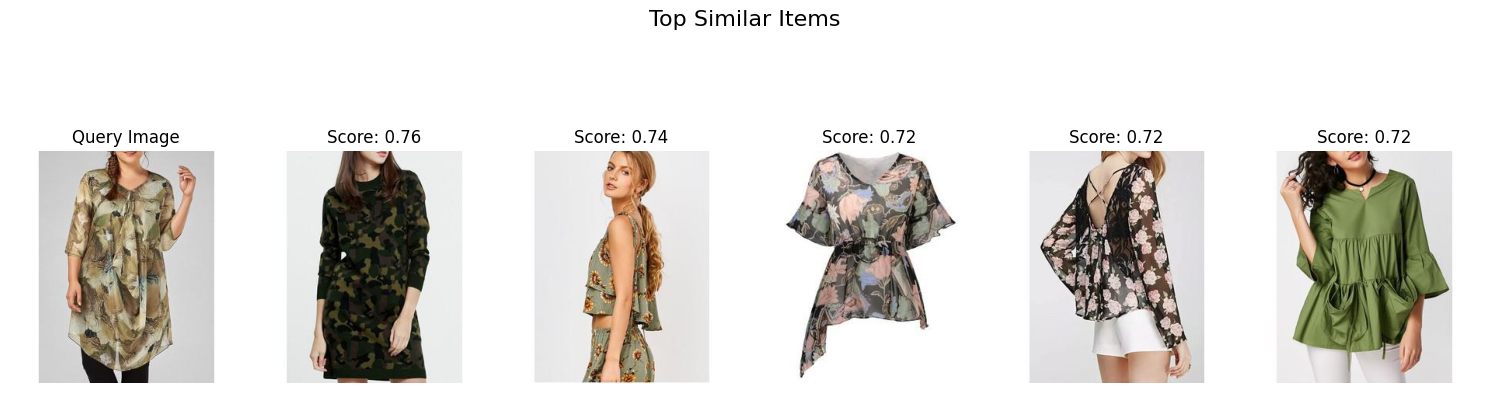

In [12]:
image_paths_dict = {img_id: img_path for img_id, img_path in zip(image_ids, image_paths)}
show_similar_images(query_id, top_similar_items, image_paths_dict)


Query Image ID: 211990161
Similar item: 196264739, Score: 0.7644
Similar item: 207564700, Score: 0.7434
Similar item: 212049126, Score: 0.7227
Similar item: 182121986, Score: 0.7210
Similar item: 211573060, Score: 0.7176


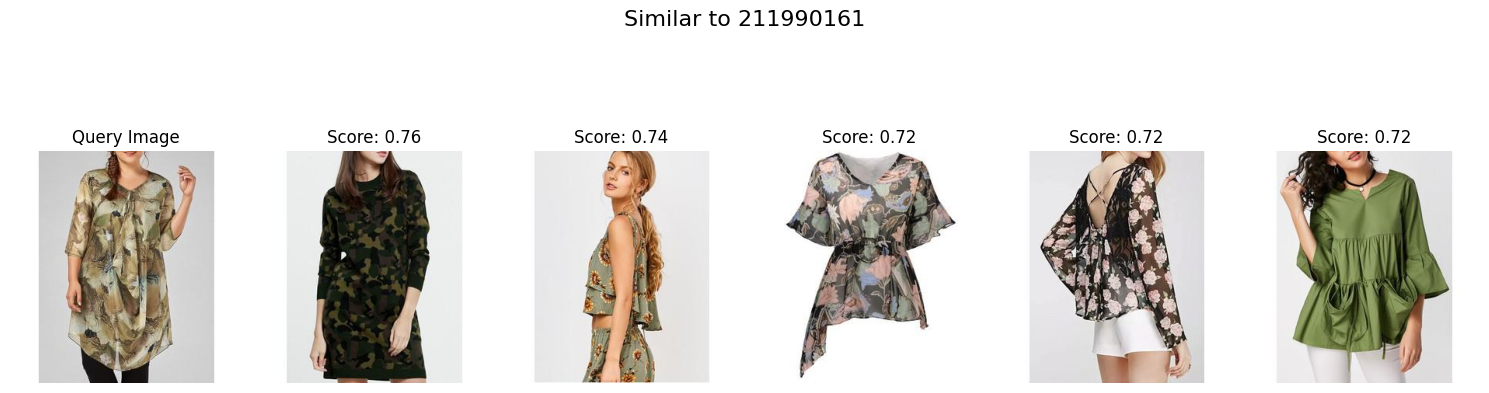


Query Image ID: 192704091
Similar item: 196459552, Score: 0.8072
Similar item: 173965526, Score: 0.7494
Similar item: 161442687, Score: 0.7462
Similar item: 164333076, Score: 0.7461
Similar item: 137883667, Score: 0.7399


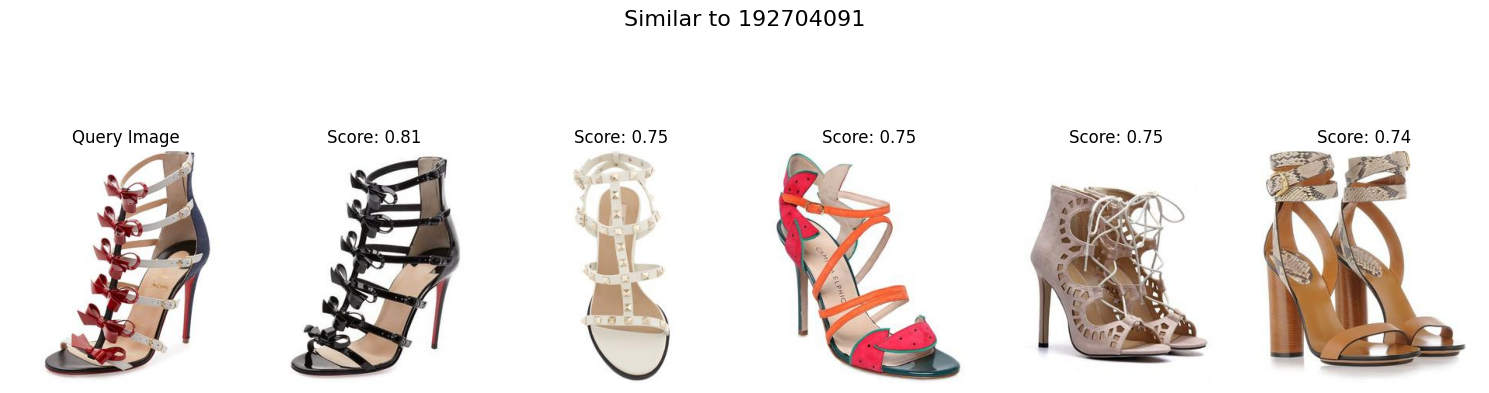


Query Image ID: 149817672
Similar item: 120961245, Score: 0.9554
Similar item: 208631574, Score: 0.9529
Similar item: 115902849, Score: 0.9385
Similar item: 68589906, Score: 0.9381
Similar item: 123557736, Score: 0.9375


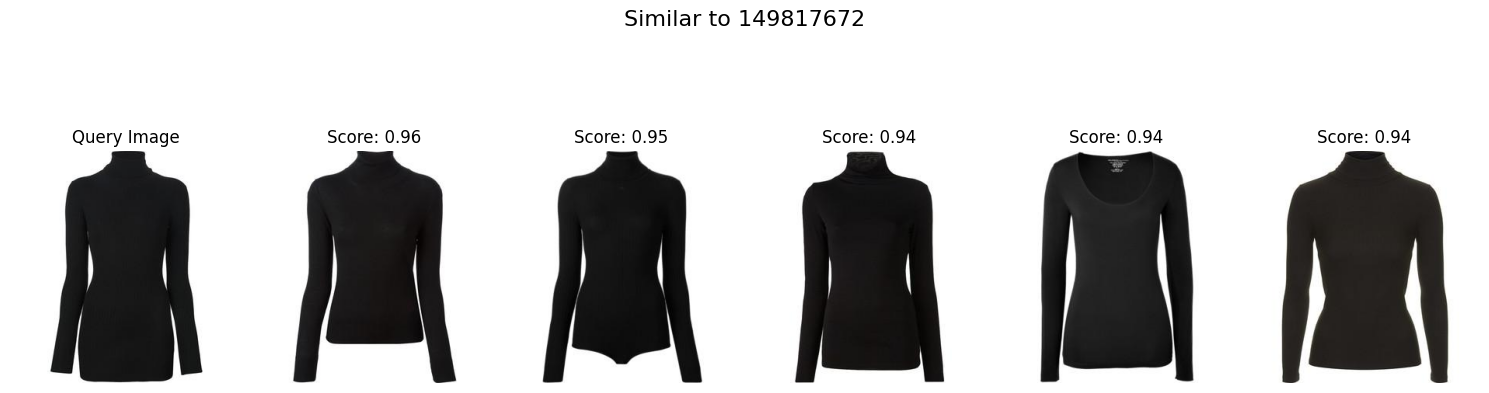


Query Image ID: 184924381
Similar item: 65703914, Score: 0.8563
Similar item: 35592172, Score: 0.8212
Similar item: 192183479, Score: 0.8205
Similar item: 134602867, Score: 0.8187
Similar item: 145630444, Score: 0.8116


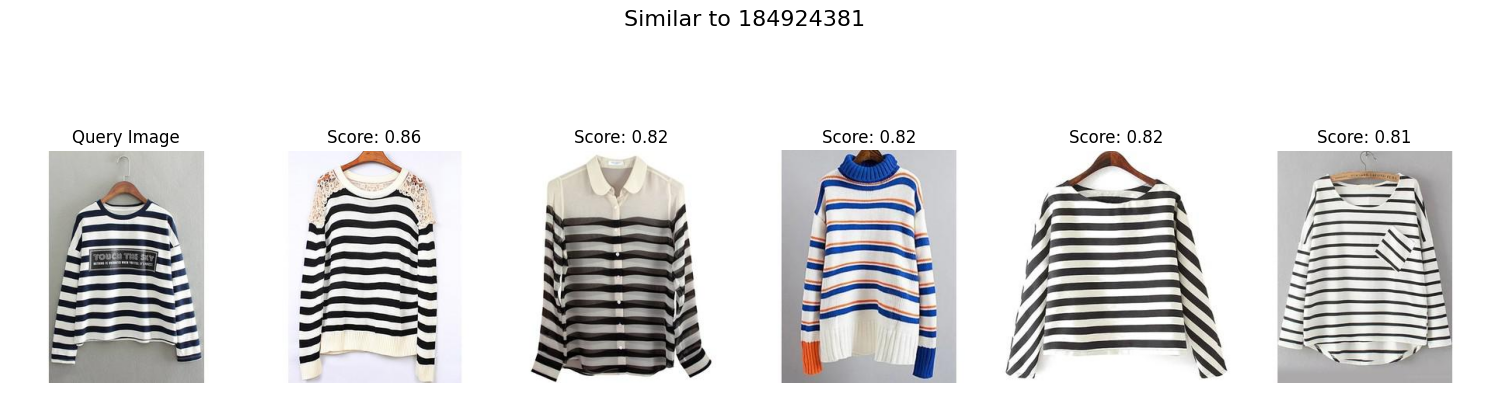


Query Image ID: 173407276
Similar item: 158759046, Score: 0.9774
Similar item: 177431402, Score: 0.9650
Similar item: 126582943, Score: 0.9474
Similar item: 80284265, Score: 0.9422
Similar item: 197564561, Score: 0.9415


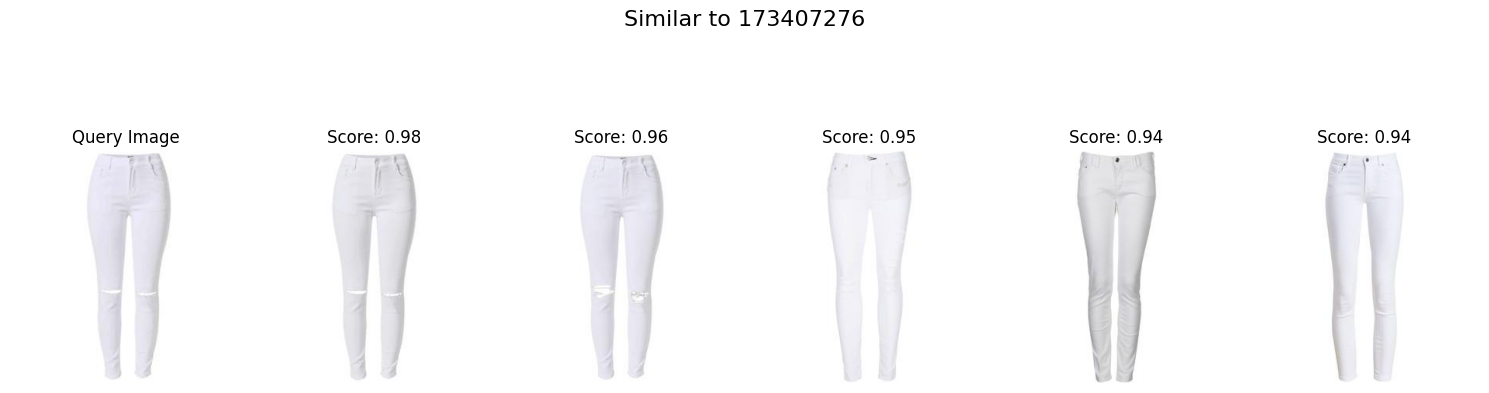


Query Image ID: 190235023
Similar item: 175271081, Score: 0.8157
Similar item: 176395981, Score: 0.7992
Similar item: 102860876, Score: 0.7928
Similar item: 149608085, Score: 0.7877
Similar item: 209113720, Score: 0.7853


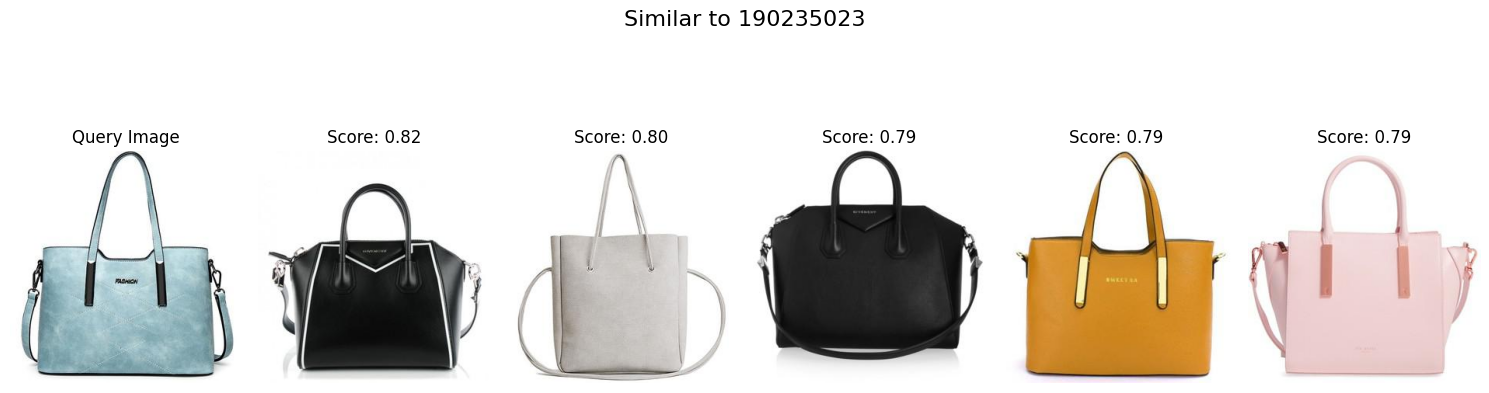


Query Image ID: 203920987
Similar item: 154922860, Score: 0.5830
Similar item: 172316883, Score: 0.5805
Similar item: 179864800, Score: 0.5762
Similar item: 129435639, Score: 0.5737
Similar item: 208986394, Score: 0.5737


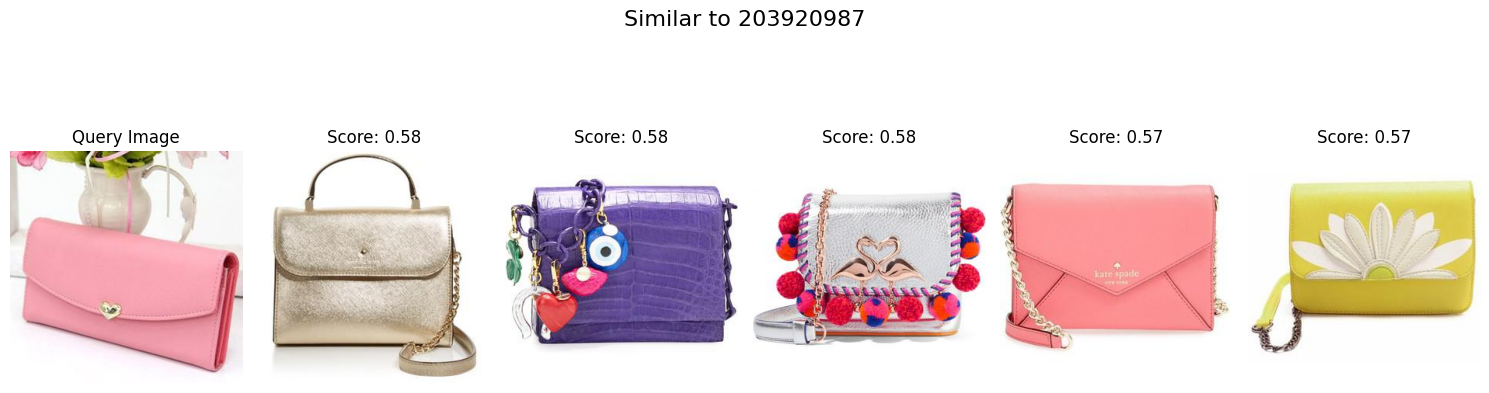


Query Image ID: 117427809
Similar item: 145104215, Score: 0.8382
Similar item: 112510894, Score: 0.8304
Similar item: 141588506, Score: 0.8301
Similar item: 142464061, Score: 0.8213
Similar item: 132681248, Score: 0.8099


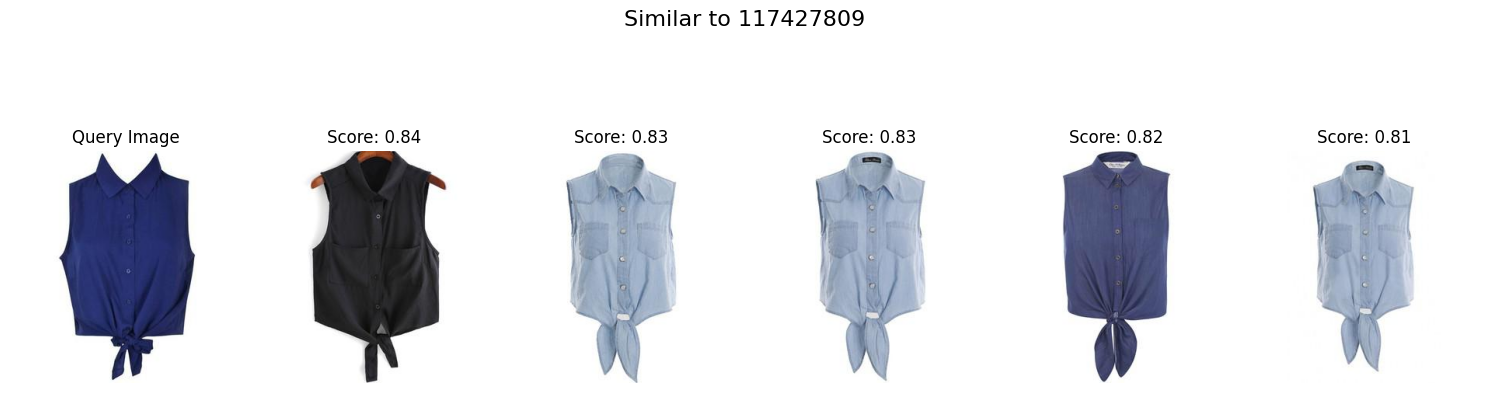


Query Image ID: 197823931
Similar item: 190436227, Score: 0.8101
Similar item: 181836465, Score: 0.7974
Similar item: 193296813, Score: 0.7854
Similar item: 198096830, Score: 0.7837
Similar item: 195621521, Score: 0.7799


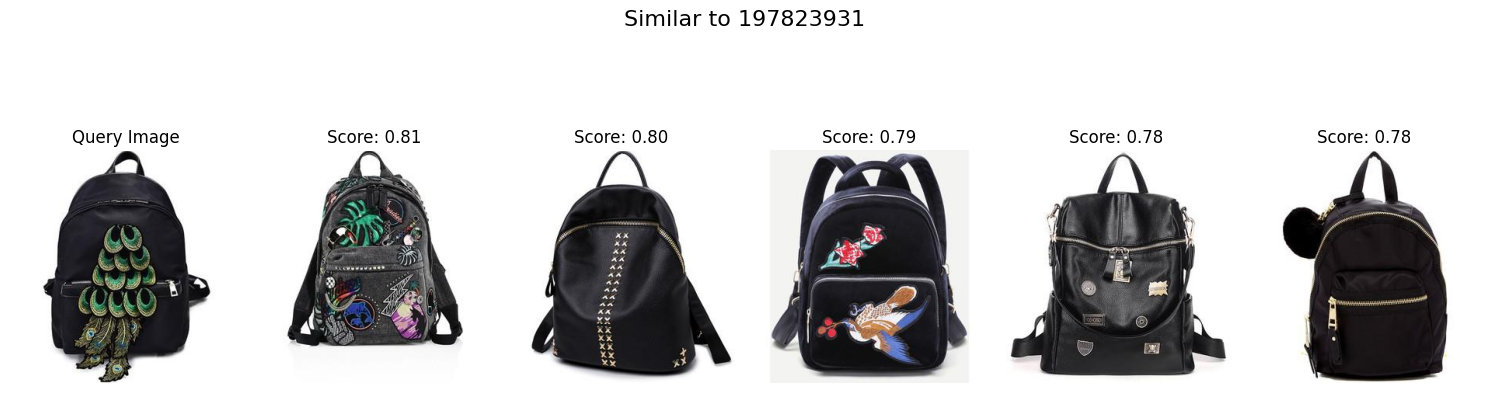


Query Image ID: 203116108
Similar item: 212362314, Score: 0.9054
Similar item: 201060671, Score: 0.9046
Similar item: 181943377, Score: 0.9005
Similar item: 153923453, Score: 0.8981
Similar item: 188224344, Score: 0.8966


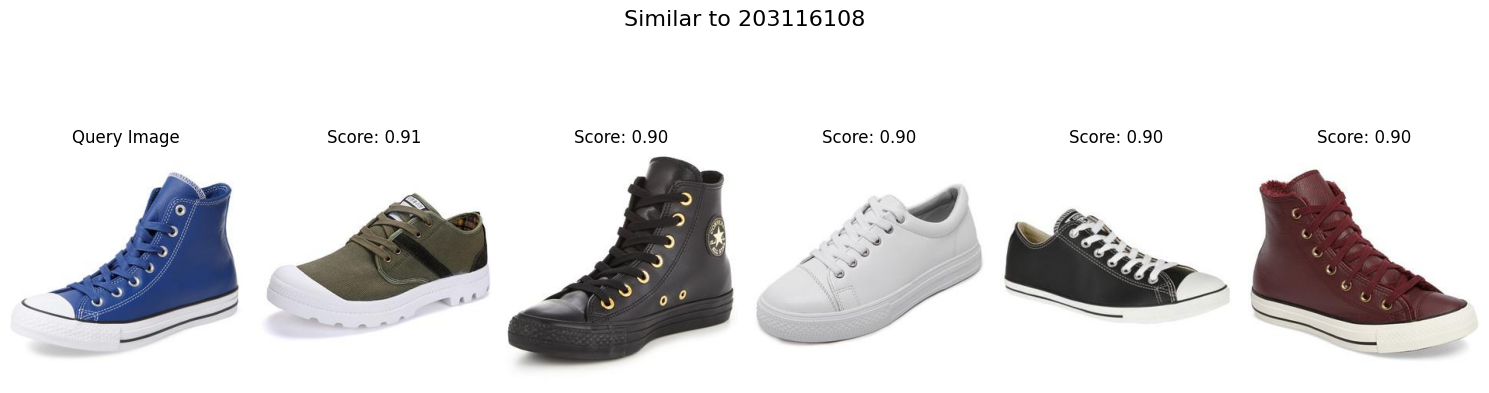

In [16]:
query_ids = [
    "211990161", "192704091", "149817672", "184924381", "173407276",
    "190235023", "203920987", "117427809", "197823931", "203116108"
]

# Make sure you have this dictionary already
image_paths_dict = {img_id: img_path for img_id, img_path in zip(image_ids, image_paths)}

# Loop through each query ID and show similar items
for query_id in query_ids:
    try:
        top_similar_items = find_similar_items(
            query_id, image_features, item_category_lookup, grouped_map, top_k=5
        )

        print(f"\nQuery Image ID: {query_id}")
        for item_id, sim_score in top_similar_items:
            print(f"Similar item: {item_id}, Score: {sim_score:.4f}")

        # Show the images
        show_similar_images(query_id, top_similar_items, image_paths_dict, title=f"Similar to {query_id}")

    except Exception as e:
        print(f"Error processing {query_id}: {e}")
